# Bottom pressure


We are interested in signals that predict the onset and then measure the progress of the next eruption at Axial Seamount. Long-term trends in bottom pressure over a magma chamber should reveal inflation; and this should correlate in some way with tilt given enough precision. 


As a start let's try and unpack some bottom pressure data at Axial, clean it up and do some averaging. 

## Needed

* Data retrieval story (not just 'I know a guy named Don')


## Data quality overview


### Summary


There are two major data quality issues and lots of bloat in the NetCDF file. The data itself looks good on a tidal time scale and on a wave time scale the noise is comparable to signal.


### Detail


- The data are simple: Just timestamps and pressures: At 20 samples per second
- In what follows we consider an 8-day duration data file. 
    - This particular file starts out at one sample per second and then soon switches gears to 20 samples/sec: **Data quality issue 1**
- Zoomed out the pressure follows a tidal signal with amplitude of a couple of meters
    - The tidal signal is frequently interrupted by brief (a few samples long) spikes 
    - These go to lower pressure, less by a meter or two. 
    - This looks to me like a capacitor discharge dropping a voltage spike into an ADC
    - It is clearly random and not a real signal. 
    - We see about five per hour on average. **Data quality issue 2**
- Zooming in to very fine time resolution the signal has vertical structure (comparable to wave motion) and noise. 
    - These are of comparable vertical scale, about 4 cm. 


There are 15 different Data Variables of which only two -- time and pressure -- are sensor data. 
I calculate each observation (again at 20 per second) requires 125 bytes where time and pressure require only 12 bytes. 
If I did that right 125 bytes x 8 days x 20 samples / second is 1.7GB but the NetCDF file is only 0.5GB for 12 million observations; so either the file is compressed or I'm just wrong on some count.

In [3]:
# mini-source control
# copied to tilt on 24-SEP-2020

pangeo_jupyter = False

import os
import sys
import time

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'

if pangeo_jupyter: data_dir = home_dir + '/data/'
else: data_dir = '/data/'

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))
print('the data directory is', data_dir, '\n')

# Some notes on writing movies (ongoing project)
#     This may be necessary on Pangeo: conda install -c conda-forge ffmpeg -y -q       
#       ... noting that -y skips dialogs; -q reduces stdout clutter
#     Note: On Pangeo `which ffmpeg` returns `/srv/conda/envs/notebook/bin/ffmpeg`
#       ... plt.rcParams['animation.ffmpeg_path'] = '/srv/conda/envs/notebook/bin/ffmpeg' 
#       ... (matplotlib must see the movie writer 'ffmpeg')

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors   # map data values to colors

import warnings
# turn off warnings using: warnings.filterwarnings("ignore")

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pandas as pd
import xarray as xr

# doy = day of year, indexed from 1 (1-JAN)
# Day of year calculated directly from a datetime64
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')


Jupyter Notebook running Python 3
the data directory is /data/ 



In [4]:
ds=xr.open_dataset(data_dir + 'botpt/botpt.nc')
ds

<xarray.Dataset>
Dimensions:                      (obs: 12724319)
Coordinates:
  * obs                          (obs) int32 0 1 2 ... 12724317 12724318
Data variables:
    preferred_timestamp          (obs) object ...
    sensor_id                    (obs) object ...
    bottom_pressure_qc_executed  (obs) uint8 ...
    date_time_string             (obs) object ...
    port_timestamp               (obs) datetime64[ns] ...
    press_trans_temp             (obs) float64 ...
    deployment                   (obs) int32 ...
    bottom_pressure_qc_results   (obs) uint8 ...
    id                           (obs) |S36 ...
    ingestion_timestamp          (obs) datetime64[ns] ...
    bottom_pressure              (obs) float32 ...
    internal_timestamp           (obs) datetime64[ns] ...
    time                         (obs) datetime64[ns] ...
    time_sync_flag               (obs) object ...
    driver_timestamp             (obs) datetime64[ns] ...
Attributes:
    node:                            MJ03B
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               streamed
    stream:                          botpt_nano_sample
    featureType:                     point
    creator_email:                   
    publisher_name:                  Ocean Observatories Initiative
    date_modified:                   2020-08-11T12:52:50.977441
    keywords:                        
    cdm_data_type:                   Point
    references:                      More information can be found at http://...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    date_created:                    2020-08-11T12:52:50.977430
    id:                              RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    requestUUID:                     2d299be8-1321-4b2b-8b74-fbf136458209
    contributor_role:                
    summary:                         Dataset Generated by Stream Engine from ...
    keywords_vocabulary:             
    institution:                     Ocean Observatories Initiative
    naming_authority:                org.oceanobservatories
    feature_Type:                    point
    infoUrl:                         http://oceanobservatories.org/
    license:                         
    contributor_name:                
    uuid:                            2d299be8-1321-4b2b-8b74-fbf136458209
    creator_name:                    Ocean Observatories Initiative
    title:                           Data produced by Stream Engine version 1...
    sensor:                          09-BOTPTA304
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    acknowledgement:                 
    Conventions:                     CF-1.6
    project:                         Ocean Observatories Initiative
    source:                          RS03ASHS-MJ03B-09-BOTPTA304-streamed-bot...
    publisher_url:                   http://oceanobservatories.org/
    creator_url:                     http://oceanobservatories.org/
    nodc_template_version:           NODC_NetCDF_TimeSeries_Orthogonal_Templa...
    subsite:                         RS03ASHS
    processing_level:                L2
    history:                         2020-08-11T12:52:50.977322 generated fro...
    time_coverage_start:             2017-08-15T00:10:37
    time_coverage_end:               2017-08-22T23:59:59.950000
    time_coverage_resolution:        P0.05S
    geospatial_lat_min:              45.93363
    geospatial_lat_max:              45.93363
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       0.1
    geospatial_lon_min:              -130.01368
    geospatial_lon_max:              -130.01368
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.1
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  0.1
    geospatial_vertic

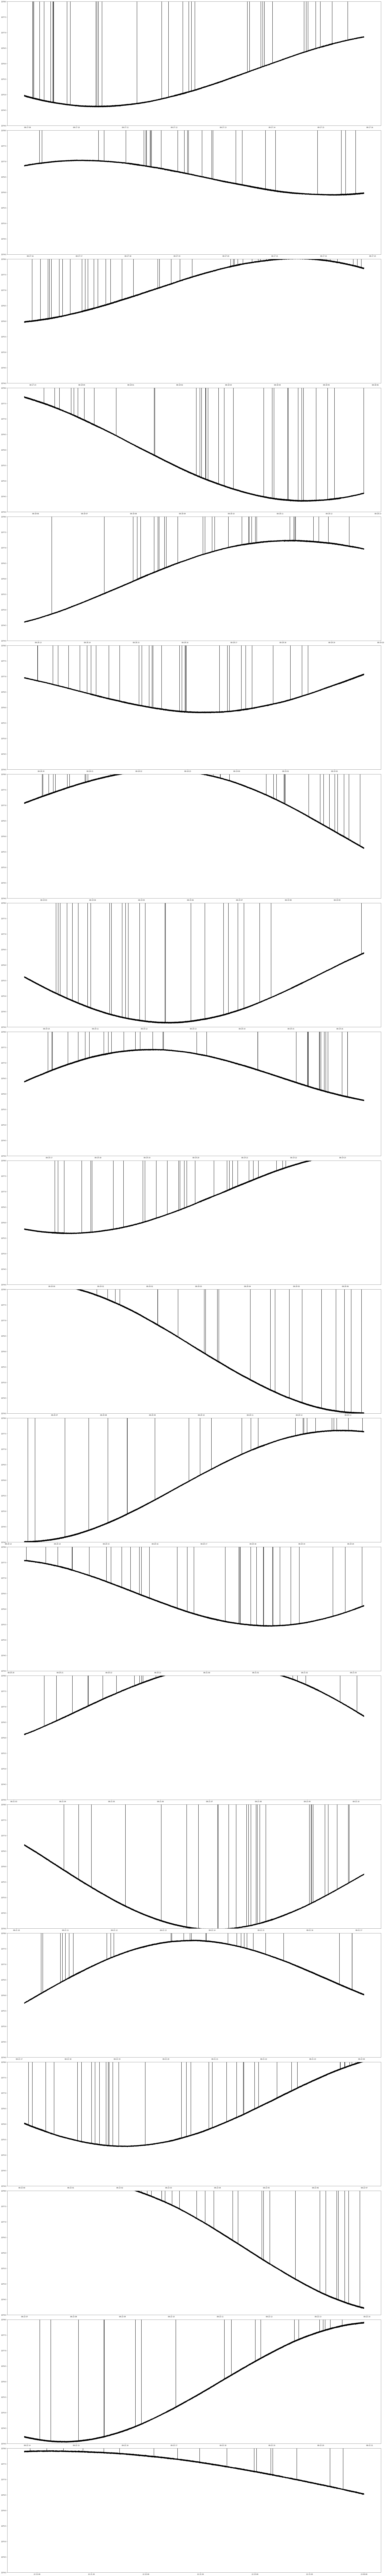

In [24]:
tmp=[]
tmptime=[]
nplots = 20                     # this can be 40 if you like

startindex = 3000000
datablock = 500000             # for 20 samples / sec use 72000 to get one hour
                               # for 1 sample / sec use a small startindex and datablock of say 200k 

for i in range(nplots):
    tmp.append(ds.isel(obs=slice(startindex + i*datablock, startindex + i*datablock + datablock)).bottom_pressure)
    tmptime.append(ds.isel(obs=slice(startindex + i*datablock, startindex + i*datablock + datablock)).time)

fig, axs = plt.subplots(nplots, 1, figsize=(36, 12*nplots), tight_layout=True)

for i in range(nplots):
    axs[i].plot(tmptime[i], tmp[i], color='k')
    axs[i].set(ylim = (2274, 2278))


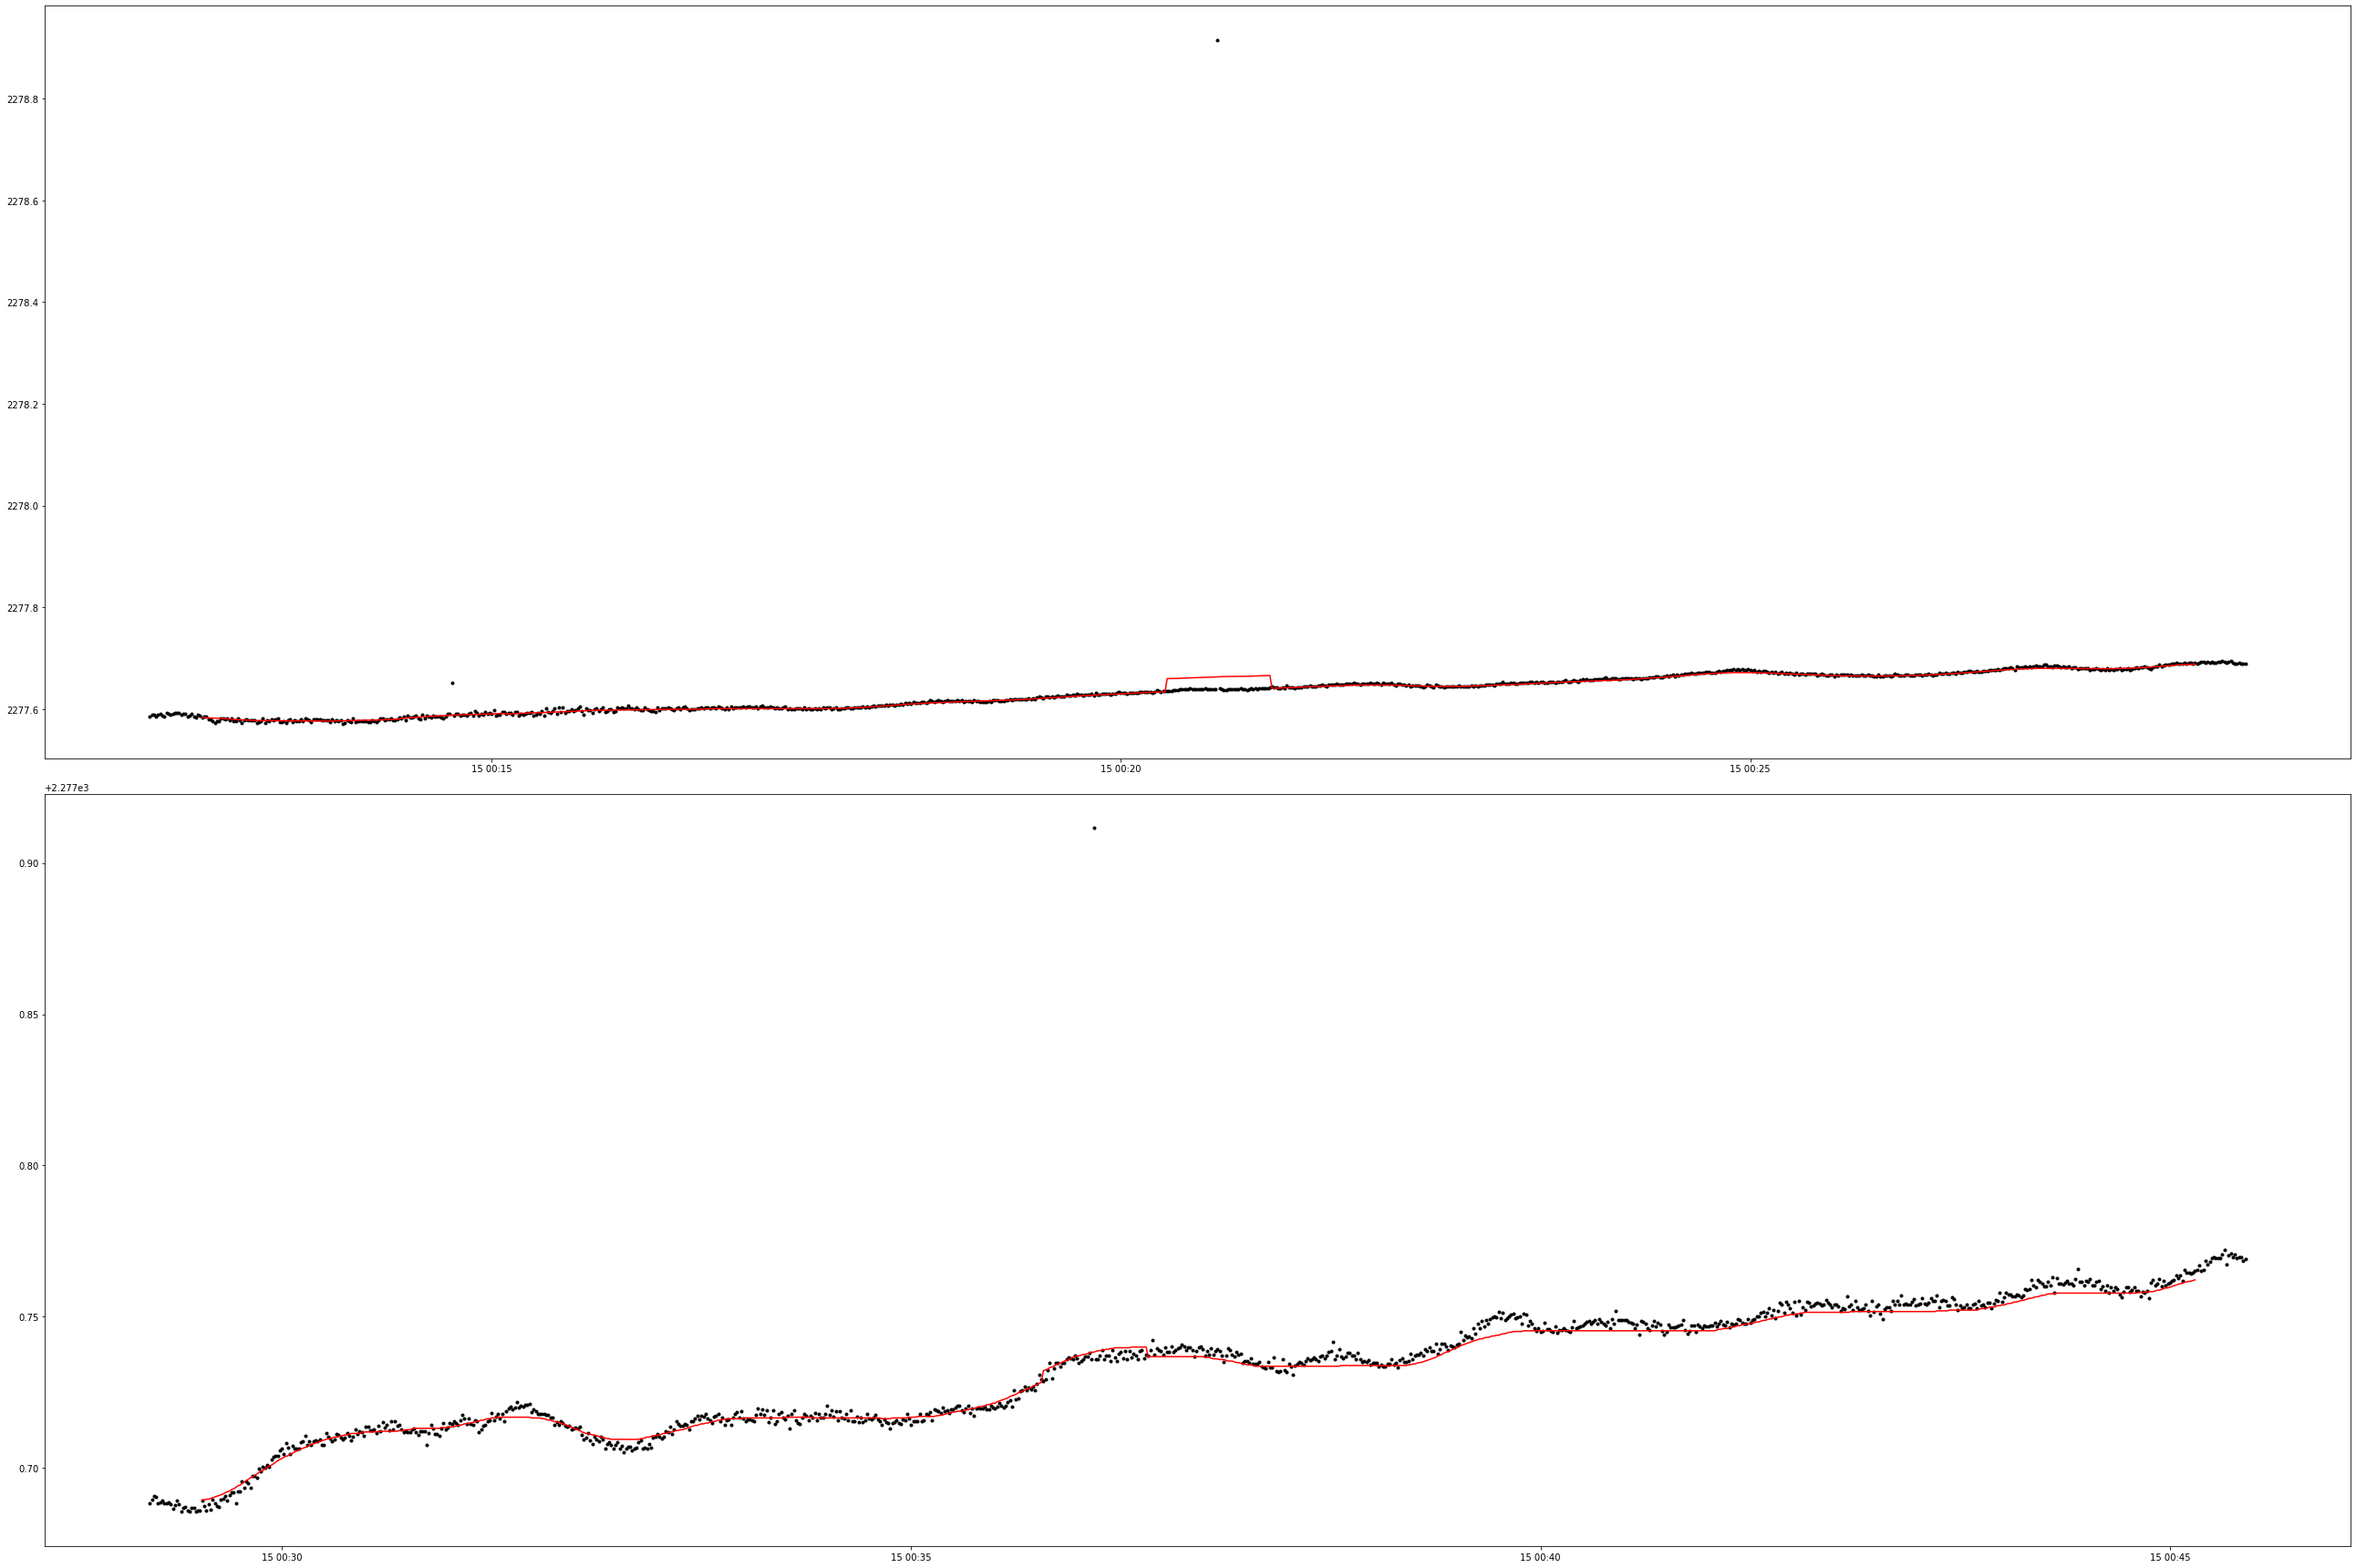

In [23]:
tmpsub, tmpsubtime, tmproll = [], [], []

nobs=50
nplots = 2
datablock = 1000             
slice_start = 100
for i in range(nplots):
    tmpsub.append(tmp[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)))
    tmpsubtime.append(tmptime[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)))
    tmproll.append(tmp[0].isel(obs=slice(slice_start + i*datablock, slice_start + i*datablock + datablock)).rolling(obs=nobs, center=True).mean())

fig, axs = plt.subplots(nplots, 1, figsize=(36, 12*nplots), tight_layout=True)

for i in range(nplots):
    axs[i].plot(tmpsubtime[i], tmproll[i], color='r')
    axs[i].scatter(tmpsubtime[i], tmpsub[i], color='k', marker='.')
    # axs[i].set(ylim = (2275.95, 2276.05))

In [168]:
ds.time[0:10] # suspicious one sample per second, not 20...

<xarray.DataArray 'time' (obs: 10)>
array(['2017-08-15T00:10:37.000000000', '2017-08-15T00:10:38.000000000',
       '2017-08-15T00:10:39.000000000', '2017-08-15T00:10:40.000000000',
       '2017-08-15T00:10:41.000000000', '2017-08-15T00:10:42.000000000',
       '2017-08-15T00:10:43.000000000', '2017-08-15T00:10:44.000000000',
       '2017-08-15T00:10:45.000000000', '2017-08-15T00:10:46.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

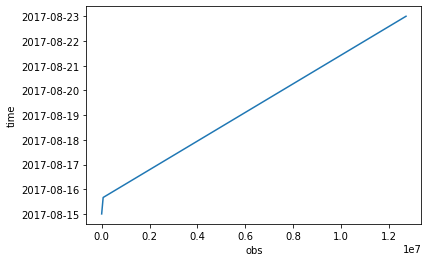

In [169]:
# Smoking gun: Sometimes the data are one sample per second, sometimes 20 samples per second
ds.time.plot()

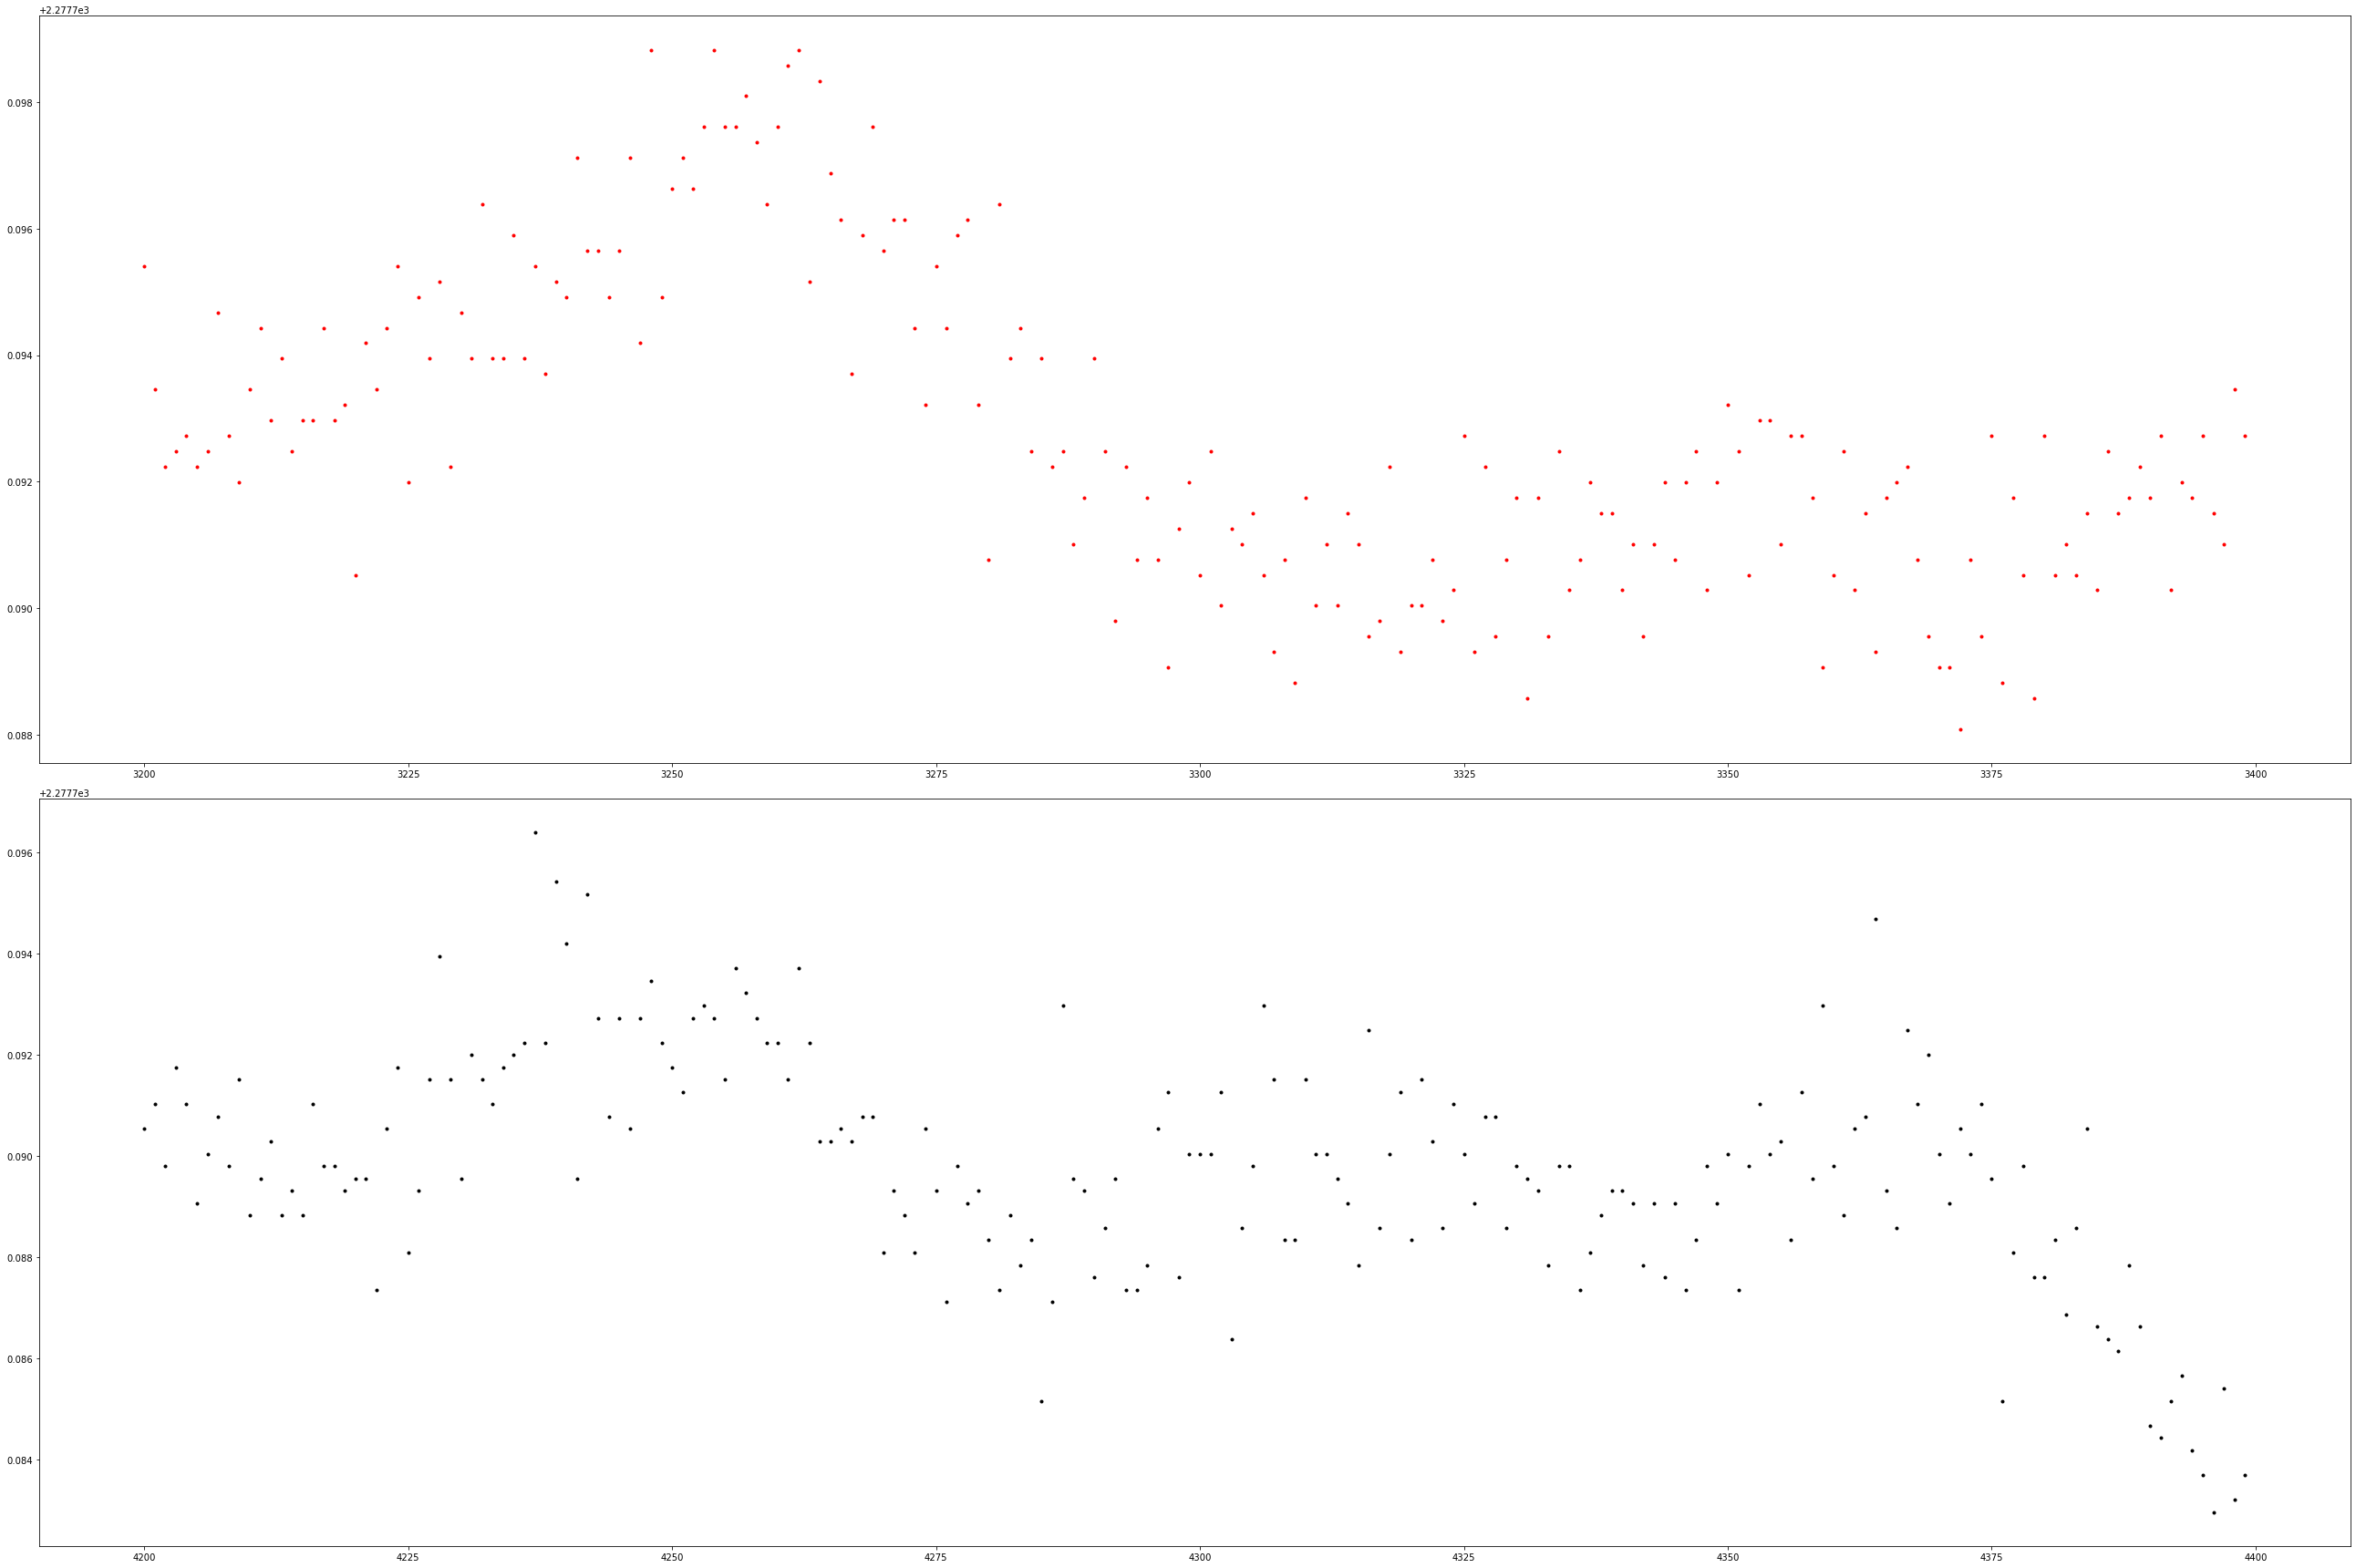

In [115]:
fig, axs = plt.subplots(2, 1, figsize=(36, 24), tight_layout=True)

tmp1 = tmp[0].isel(obs=slice(3200,3400))
tmp2 = tmp[0].isel(obs=slice(4200,4400))

axs[0].scatter(tmp1.obs, tmp1, marker='.', color='r')
axs[1].scatter(tmp2.obs, tmp2, marker='.', color='k')

# Suspect now that we see this is one sample per second

## Average

Let's get a single depth for the entire dataset. Then go get a couple more near this time; and then go to later in the record by a couple years and see if there is a consistent change.

In [33]:
ds=xr.open_dataset(data_dir + 'botpt/botpt.nc').swap_dims({'obs':'time'})
da_day = ds.bottom_pressure.resample(time='1D').mean()
da_day

<xarray.DataArray 'bottom_pressure' (time: 8)>
array([2276.119 , 2276.3008, 2276.3484, 2276.3623, 2276.364 , 2276.3635,
       2276.3672, 2276.3765], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-15 2017-08-16 ... 2017-08-22

In [38]:
ds.time[0], ds.time[-1]

(<xarray.DataArray 'time' ()>
 array('2017-08-15T00:10:37.000000000', dtype='datetime64[ns]')
 Coordinates:
     obs      int32 0
     time     datetime64[ns] 2017-08-15T00:10:37
 Attributes:
     long_name:      time
     standard_name:  time
     axis:           T,
 <xarray.DataArray 'time' ()>
 array('2017-08-22T23:59:59.949999616', dtype='datetime64[ns]')
 Coordinates:
     obs      int32 12724318
     time     datetime64[ns] 2017-08-22T23:59:59.949999616
 Attributes:
     long_name:      time
     standard_name:  time
     axis:           T)

In [34]:
da_day.mean()

<xarray.DataArray 'bottom_pressure' ()>
array(2276.3252, dtype=float32)

In [35]:
xr.open_dataset(data_dir + 'botpt/botpt.nc').swap_dims({'obs':'time'}).bottom_pressure.resample(time='1D').mean().mean()

<xarray.DataArray 'bottom_pressure' ()>
array(2276.3252, dtype=float32)

In [36]:
xr.open_dataset(data_dir + 'botpt/botpt.nc').swap_dims({'obs':'time'}).bottom_pressure.mean()

<xarray.DataArray 'bottom_pressure' ()>
array(2276.3428, dtype=float32)

In [37]:
xr.open_dataset(data_dir + 'botpt/botpt.nc').bottom_pressure.mean()

<xarray.DataArray 'bottom_pressure' ()>
array(2276.3428, dtype=float32)

In [40]:
srcfiles = ['botpt-2017-08-15.nc',
            'botpt-2017-08-23.nc',
            'botpt-2017-08-30.nc',
            'botpt-2017-09-07.nc',
            'botpt-2017-09-14.nc',
            'botpt-2017-09-22.nc',
            'botpt-2020-07-15.nc',
            'botpt-2020-07-19.nc',
            'botpt-2020-07-23.nc',
            'botpt-2020-07-26.nc',
            'botpt-2020-07-30.nc',
            'botpt-2020-08-03.nc']

In [41]:
botpt_dir = data_dir + 'botpt/'

In [43]:
mean_pressure_per_file = [xr.open_dataset(botpt_dir + src).bottom_pressure.mean() for src in srcfiles]
mean_pressure_per_file

[<xarray.DataArray 'bottom_pressure' ()>
 array(2276.3428, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2276.31, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2276.3313, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2276.2893, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2276.259, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2276.306, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.6677, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.6035, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.5845, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.5872, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.62, dtype=float32),
 <xarray.DataArray 'bottom_pressure' ()>
 array(2275.5767, dtype=float32)]

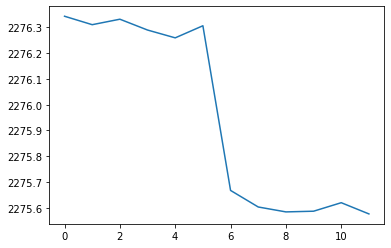

In [44]:
plt.plot(mean_pressure_per_file)

In [8]:
import glob
mean_pressure = []
mean_time = []
for this_file in glob.glob('/data/botpt/deployment*.nc'): 
    print(this_file)

/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20170830T120000-20170906T235959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20170907T000000-20170914T175959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20170914T180000-20170922T055959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20170922T060000-20170929T175959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20170929T180000-20171007T055959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20171007T060000-20171014T175959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20171014T180000-20171022T055959.950000.nc
/data/botpt/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20171022T060000-20171029T175959.950000.nc
/data/bo